In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import re
import seaborn as sns

from collections import OrderedDict
from functools import reduce
from operator import add

# Create Output Directory


In [2]:
output_dir_path: str = os.path.join(os.getcwd(), "paper_figures")

try:
    os.mkdir(output_dir_path)
except Exception:
    pass
finally:
    pass

## Load Data


In [3]:
path: str = os.path.join(os.path.join(os.path.dirname("__file__")), "outputs")
folders:list = [f for f in os.listdir(path)]

data: pd.DataFrame = pd.DataFrame(columns=["metric", "submetric", "value", "task", "result", "degree"])

for folder in folders:
    path_tmp: str = os.path.join(path, folder)
    # results: list = [f for f in os.listdir(path_tmp) if re.match(".*_results_data.p", f)]


    df: pd.DataFrame = pd.DataFrame(columns=["metric", "submetric", "value", "task", "result", "degree"])
    
    # loop
    toVis: list = [
        #'.mix_results_data.p',
        '.swapped_words_results_data.p',
        '.repetition_results_data.p',
        '.dropped_words_results_data.p',
        '.posdrop_results_data.p',
        '.negation_results_data.p']

    for task in toVis:

        f = open(os.path.join(path_tmp, task), 'rb')
        df_tmp = pickle.load(f)
        f.close()

        taskName: re.Match = re.search("^\.(.*)_r", task)
        assert taskName is not None, "Naming convention error. Make sure result files are named '.[TASK]_results_data.p'"
        taskName: str = taskName.group(1)

        df_tmp['task'] = taskName
        
        # append
        df = df.append(df_tmp)

    df['result'] = folder
    # append
    assert df['metric'].unique()[0] not in data['metric'].unique(), "Metric has already been added to dataframe. Are there only folders with unique metric setups?"
    data = data.append(df)

## Clean Data

In [4]:
data = data[
    (data['submetric'] != 'P') &
    (data['submetric'] !=  'R') &
    (data['submetric'] !=  'Schnabel_div') &
    (data['submetric'] !=  'Schnabel_qul') &
    (data['submetric'] !=  'CAPTURE') &
    (data['metric'] != 'Mark-Evaluate (Original, SBERT)') &
    (data['metric'] != 'Mark-Evaluate (Theorem based, SBERT)') &
    (data['metric'] != 'Mark-Evaluate (Original, BERT)') &
    (data['task'] != 'mix')].copy()

## Rename labels which are too long

### Metric Names


In [5]:
data.loc[data['metric'] == 'Mark-Evaluate (Theorem based, BERT)',  'metric'] = 'ME-BRT'
# data.loc[data['metric'] == 'Mark-Evaluate (Theorem based, SBERT)', 'metric'] = 'ME-SBRT'
data.loc[data['metric'] == 'BERTScore', 'metric'] = 'BRTScr'
data.loc[data['metric'] == 'BERTScore (idf)', 'metric'] = 'BRTScr-idf'
data.loc[data['metric'] == 'BLEURT-Base-128', 'metric'] = 'BLRT-B-128'

### Degree Labels

In [6]:
data.loc[data['degree'] == 'Rep. len.: 0.0 * len(sents)', 'degree'] = 0.0
data.loc[data['degree'] == 'Rep. len.: 0.25 * len(sents)', 'degree'] = 0.25
data.loc[data['degree'] == 'Rep. len.: 0.5 * len(sents)', 'degree'] = 0.5
data.loc[data['degree'] == 'Rep. len.: 0.75 * len(sents)', 'degree'] = 0.75
data.loc[data['degree'] == 'Rep. len.: 1.0 * len(sents)', 'degree'] = 1.0

## Create Plots

In [7]:
data['metric_submetric'] = data['metric'].astype(str) + ' ' + data['submetric'].astype(str)

In [8]:
color_palette = sns.color_palette("Set2", n_colors=len(data['metric_submetric'].unique()))

## Lineplots

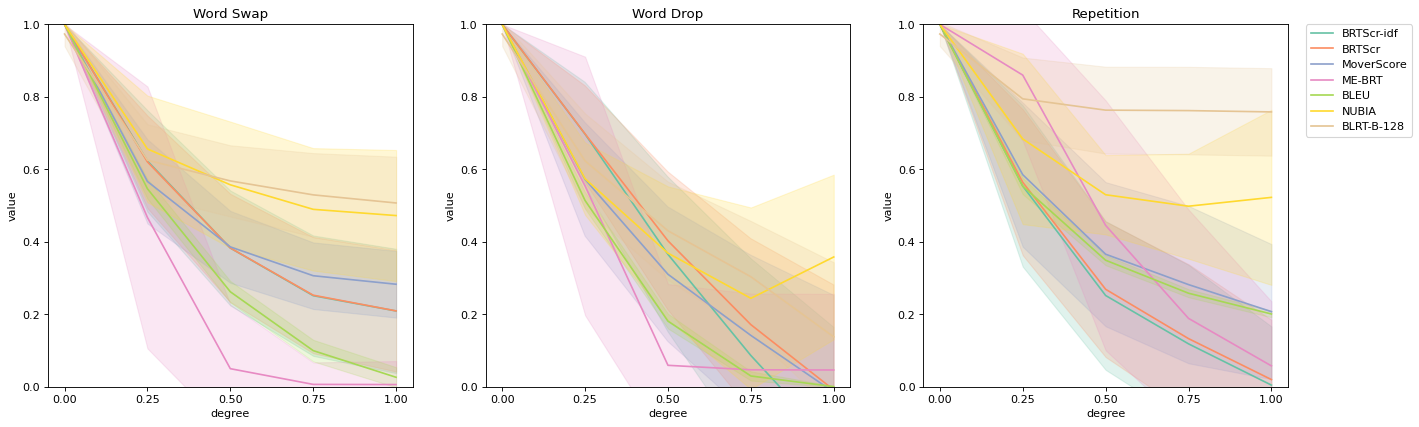

In [9]:
fig = plt.figure(figsize=(20, 6), dpi=80)

# add subplots
for i, (task, title) in enumerate([('swapped_words', 'Word Swap'), ('dropped_words', 'Word Drop'), ('repetition', 'Repetition')], 1):
    plt.subplot(1, 3, i)
    ax = sns.lineplot(
        x="degree",
        y="value",
        hue="metric",
        data=data[data['task'] == task],
        ci='sd',
        err_style='band',
        palette=color_palette)
    # ax = sns.boxplot(x='species', y=col, data=data[data['task'] == col], hue='species')
    ax.get_legend().remove()
    plt.title(title)
    plt.ylim([0, 1])
    plt.xticks([0,0.25,0.5,0.75,1])

# add legend
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(.75, 0.98))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Overall title
# fig.suptitle('Tasks with ordered levels of impairment')

plt.savefig(output_dir_path + '/' + 'lineplots.png')
plt.show()


## Include Standard Deviation

In [10]:
data_pos_: pd.DataFrame = data[data['task'] == 'posdrop'].copy()

In [11]:
bleu_df: pd.DataFrame = data_pos_[data_pos_['metric'] == 'BLEU'].groupby(['metric_submetric', 'degree','task'], as_index=False).mean().copy()

In [12]:

pos_data_final: pd.DataFrame = pd.merge(data_pos_, (bleu_df.rename(columns={'value': 'BLEU_AVG'}))[['degree', 'BLEU_AVG']], how='outer', on=['degree']).copy()
pos_data_final['BLEU_DIFF'] = pos_data_final['value'] - pos_data_final['BLEU_AVG']

In [13]:
box_data: pd.DataFrame = data.copy()
box_data = box_data.loc[(box_data['degree'] != 'original') & (box_data['degree'] != 'Original')]

### Clean for final figure

In [14]:
pos_data_final = pos_data_final.loc[(pos_data_final['degree'] != 'original') & (pos_data_final['degree'] != 'Original') & (pos_data_final['task'] != 'negation') & (pos_data_final['metric_submetric'] != 'BLEU BLEU')]

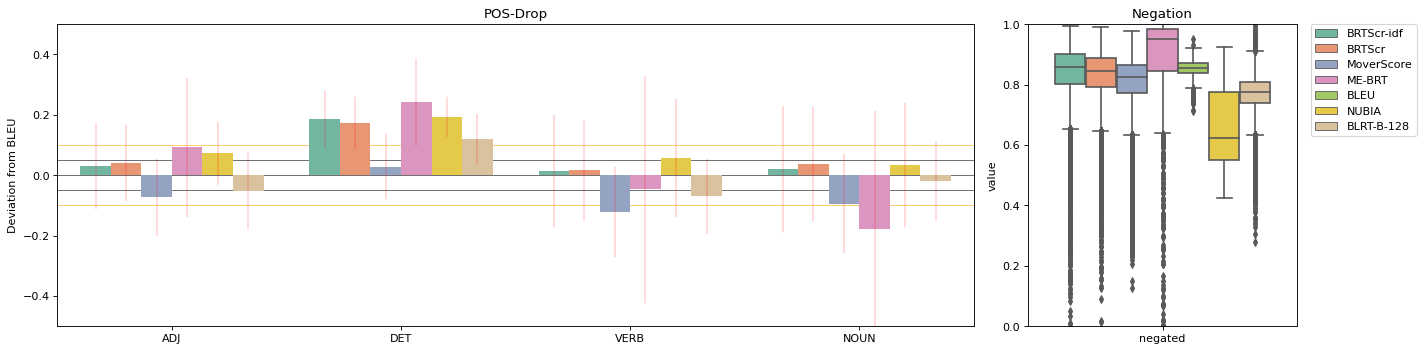

In [15]:
metrics: list = data['metric'].unique()
color_palette = sns.color_palette("Set2", n_colors=len(data['metric'].unique()))
palette= dict(zip(metrics, list(color_palette)))

fig = plt.figure(figsize=(20, 5), dpi=80)


palette2: dict = palette.copy()
del palette2["BLEU"]

# plots
gs = fig.add_gridspec(1,4)
ax1 = fig.add_subplot(gs[0, :3])
ax1 = sns.barplot(
    data=pos_data_final,
    x="degree", y="BLEU_DIFF", hue="metric",
    ci="sd", palette=palette2,
    errcolor='red', errwidth='0.25'
)
ax1.get_legend().remove()
ax1.axhline(y=0,xmin=0,xmax=3,c="black",linewidth=0.5,zorder=0)
ax1.axhline(y=0.1,xmin=0,xmax=3,c="orange",linewidth=0.5,zorder=0)
ax1.axhline(y=0.05,xmin=0,xmax=3,c="black",linewidth=0.5,zorder=0)
ax1.axhline(y=-0.1,xmin=0,xmax=3,c="orange",linewidth=0.5,zorder=0)
ax1.axhline(y=-0.05,xmin=0,xmax=3,c="black",linewidth=0.5,zorder=0)
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
ax1.set_ylabel("Deviation from BLEU")
plt.title("POS-Drop")
plt.ylim([-0.5, 0.5])

del palette2

ax2 = fig.add_subplot(gs[0, 3])
ax2 = sns.boxplot(x="degree", y="value", hue="metric", data=box_data[box_data['task'] == 'negation'], palette=palette)
ax2.get_legend().remove()
x_axis = ax2.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)
plt.title("Negation")
plt.ylim([0, 1])

# add legend
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(.75, 0.98))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.savefig(output_dir_path + '/' + 'barplots.png')
plt.show()